https://github.com/mehdi-elion/Image-Classification-Pytorch/blob/main/transfer_learning.ipynb

https://www.kaggle.com/code/tladilebohang/metal-casting-5

Paper : INTERPRETABILITY OF DEEP LEARNING MODELS FOR VISUAL DEFECT DETECTION: A PRELIMINARY STUDY

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os, sys
import copy


In [3]:
img_size = 300
width, height = img_size, img_size
IMG_SIZE = (width, height)


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'D:/Téléchargements/Datasets/hymenoptera_data/hymenoptera_data/'
data_dir = "C:\\Users\\noname\\Desktop\\Casting\\casting_data"


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

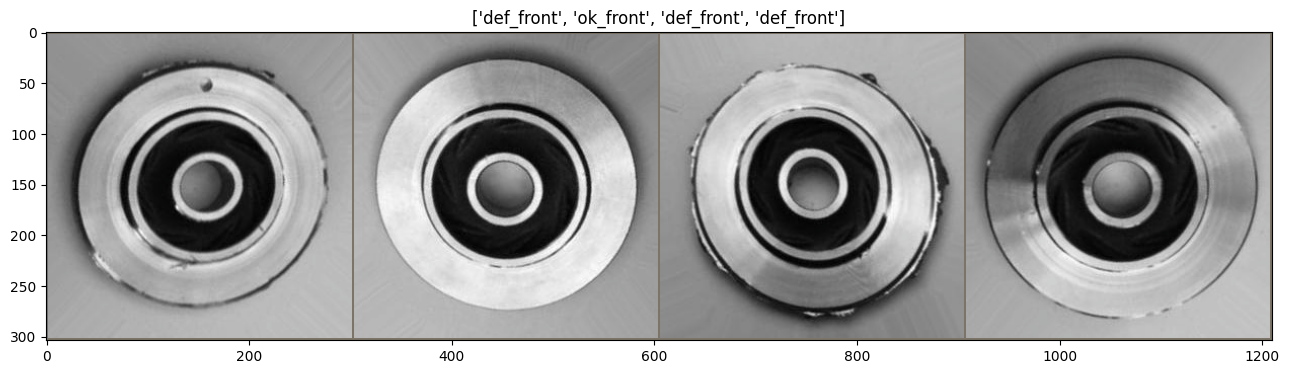

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
plt.figure(figsize=(16, 4))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(4*num_images, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(1, num_images, images_so_far)
                plt.axis('off')
                plt.title('predicted: {}'.format(class_names[preds[j]]))
                im = inputs.cpu().detach().data[j].numpy().transpose((2, 1, 0))
                im = (im - im.min()) / (im.max() - im.min())
                plt.imshow(im)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# load pre-trained backbone 
model_ft = models.vgg16(pretrained=True)

# replace classification head
num_ftrs = model_ft.classifier[6].in_features 
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

# use cuda if available
model_ft = model_ft.to(device)

# choose loss function
criterion = nn.CrossEntropyLoss()

# freeze all layers except the new one
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier[6].parameters():
    param.requires_grad = True

# choose optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6544 Acc: 0.7841
test Loss: 0.1851 Acc: 0.9077

Epoch 1/9
----------
train Loss: 0.6008 Acc: 0.8233
test Loss: 0.3374 Acc: 0.8531

Epoch 2/9
----------
train Loss: 0.5938 Acc: 0.8346
test Loss: 0.2455 Acc: 0.9007

Epoch 3/9
----------
train Loss: 0.6238 Acc: 0.8314
test Loss: 0.2936 Acc: 0.8741

Epoch 4/9
----------
train Loss: 0.5930 Acc: 0.8372
test Loss: 0.1645 Acc: 0.9245

Epoch 5/9
----------
train Loss: 0.5616 Acc: 0.8431
test Loss: 0.4757 Acc: 0.8112

Epoch 6/9
----------
train Loss: 0.5842 Acc: 0.8399
test Loss: 0.1056 Acc: 0.9636

Epoch 7/9
----------
train Loss: 0.4196 Acc: 0.8735
test Loss: 0.2131 Acc: 0.9105

Epoch 8/9
----------
train Loss: 0.3804 Acc: 0.8827
test Loss: 0.1788 Acc: 0.9259

Epoch 9/9
----------
train Loss: 0.3521 Acc: 0.8835
test Loss: 0.1701 Acc: 0.9287

Training complete in 6m 13s
Best val Acc: 0.963636


In [80]:
visualize_model(model_ft)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\datasets\folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\datasets\folder.py", line 268, in default_loader
    return pil_loader(path)
  File "C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\datasets\folder.py", line 246, in pil_loader
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\noname\\Desktop\\Casting\\casting_data\\test\\cast_ok\\cast_ok_0_863.jpeg'


<Figure size 2000x500 with 0 Axes>

In [48]:
# model summary
s = summary(model_ft, (3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

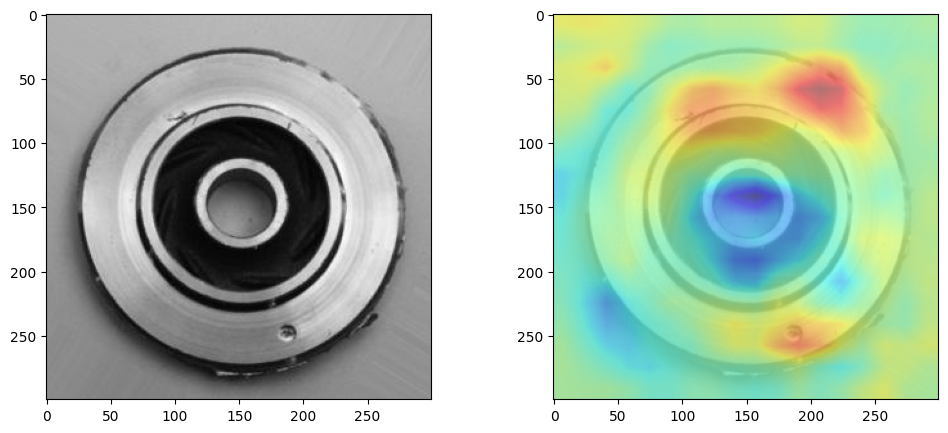

In [86]:
from captum.attr import IntegratedGradients, GuidedGradCam, LayerGradCam, LayerDeepLift
# from captum.attr.visualization import visualize_image_attr
from torchvision.io import read_image
from PIL import Image
import cv2
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
# It contains an attribute conv4, which is an instance of nn.conv2d,
# and the output of this layer has dimensions Nx50x8x8.
# It is the last convolution layer, which is the recommended
# use case for GuidedGradCAM.


net = model_ft
guided_gc = LayerGradCam(net, net.features[29])


# guided_gc = LayerDeepLift(net, net.features[29])
# guided_gc = GuidedGradCam(net, net.features[22])
# guided_gc = LayerGradCam(net, net.features[27])

foldername = os.path.join(data_dir, 'test/' + class_names[0])
imagename = np.random.choice(os.listdir(foldername), 1)[0]

img = Image.open(os.path.join(foldername, imagename))
im = np.asarray(img)

img = data_transforms['test'](img)

input = img.reshape((1,)+img.shape)
input = input.to(device)
input.requires_grad = True


# Computes guided GradCAM attributions for class 3.
# attribution size matches input size, Nx3x32x32
attribution = guided_gc.attribute(input, target=0)


grid = attribution.cpu().detach().numpy()[0,:,:,:].transpose((1,2,0))
grid = 255 * ( (grid -  grid.min()) / (grid.max() -  grid.min()) )
grid = grid.astype(np.uint8)
grid = cv2.resize(grid, (300, 300), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
plt.show()


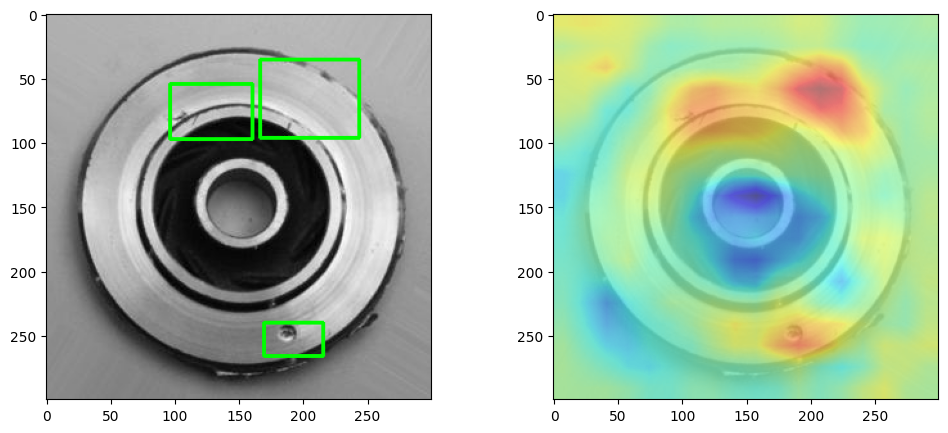

In [90]:
threshold = 180 # 임계값 설정

# threshold 이상의 값을 가지는 영역을 구합니다.
thresholded_grid = np.where(grid > threshold, grid, 0)

# threshold 이상의 값을 가지는 영역을 bounding box로 표시합니다.
contours, _ = cv2.findContours(thresholded_grid, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 이미지를 복사하여 수정 가능한 형태로 만듭니다.
im_copy = im.copy()

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(im_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(im_copy)

plt.subplot(1, 2, 2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
plt.show()
